In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import numpy as np
import torch

# sys.path.insert(0, '..')
from isegm.utils import vis, exp

from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample
from isegm.inference.predictors import get_predictor
from isegm.data.preprocess import Preprocessor

device = torch.device('cuda:0')
cfg = exp.load_config_file('config.yml', return_edict=True)

In [19]:
# Possible choices: 'GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal', 'SBD', 'BRATS', 'LIDC', 'LIDC_2D_VAL', 'LIDC_2D_256_VAL, 'BRATS_SIMPLECLICK'
DATASET = 'LIDC_2D_VAL'
dataset = utils.get_dataset(DATASET, cfg)

EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.5

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'pretrained_fixed_loading')
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS', 'FocalClick'
brs_mode = 'FocalClick'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

(512, 512, 3) uint8 0 255
[0.87664044 0.00271003 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


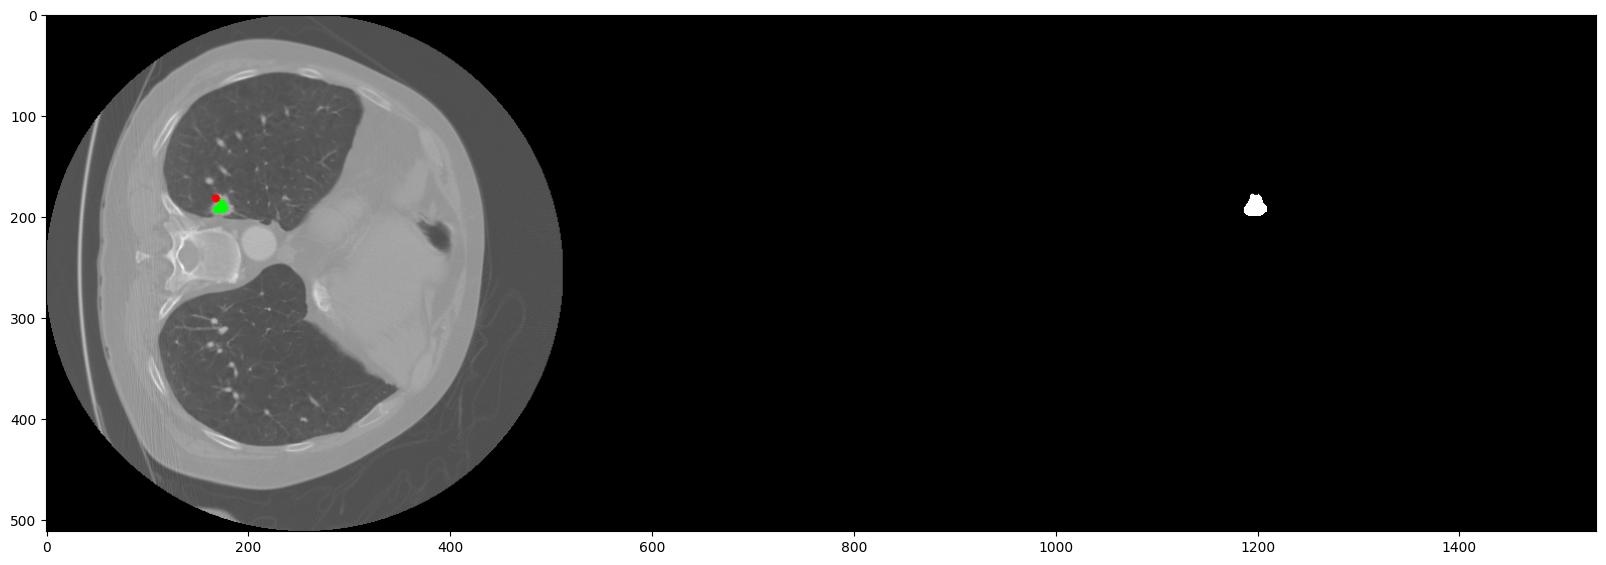

In [25]:
sample_id = 3
TARGET_IOU = 0.95

sample = dataset.get_sample(sample_id)

gt_mask = sample.gt_mask
image = sample.image

preprocess_cfg = {
    'enhancements': {
        'contrast': 1
        },
    'normalize': True,
    'windowing': {
        'enabled': False,
        'min': -1000,
        'max': 400,
    }
}

preprocessor = Preprocessor(preprocess_cfg)
image = preprocessor.preprocess(image)
print(image.shape, image.dtype, image.min(), image.max())

clicks_list, ious_arr, pred, pred_list = evaluate_sample(image, gt_mask, np.zeros_like(gt_mask), predictor, 
                                              pred_thr=MODEL_THRESH, 
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS,
                                              vis=False, progressive_mode=False)
pred_mask = pred > MODEL_THRESH

draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicks_list)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

print(ious_arr)

plt.figure(figsize=(20, 30))
plt.imshow(draw)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import base64

In [22]:

def show_animation(animation):
    html = animation.to_jshtml()
    
    return HTML(html)

def show_animation_from_file(filename):
    
    with open(filename, 'rb') as f:
        gif_data = f.read()

    gif_base64 = base64.b64encode(gif_data).decode('utf-8')

    html_code = f'<img src="data:image/gif;base64,{gif_base64}">'
    return HTML(html_code)

def save_animation(animation, filename):
    animation.save(f'{filename}.gif', writer='pillow')

In [23]:
def generate_click_animation(image, gt_mask, iou_values, clicks, predictions):
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))
        
    iou_values = np.append(np.array([0]), iou_values)
    
    num_frames = len(iou_values)
        
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Clicks: 0', fontsize=20)
    ax[0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)
    
    ax[1].axis('off')
    ax[1].imshow(image, cmap='gray')
    ax[1].set_title(f'IOU: {0.}', fontsize=20)
    
    ax[2].set_xticks(np.arange(len(iou_values)))
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlabel('Clicks')
    ax[2].set_ylabel('IOU')
    ax[2].set_title('IOU after each click', fontsize=20)
    
    plt.close()
    
    def update(frame_index):
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(f'Clicks: {frame_index}', fontsize=20)
        ax[0].contour(gt_mask, colors='b', alpha=0.5, linewidths=0.1)
        for click in clicks[:frame_index]:
            color = 'lime' if click.is_positive else 'r'
            y, x = click.coords
            ax[0].scatter(x, y, s=20, c=color)
        
        ax[1].imshow(image, cmap='gray')
        if (frame_index > 0):
            prediction_masked = np.ma.masked_where(predictions[frame_index-1] == 0, predictions[frame_index-1])
            ax[1].imshow(prediction_masked, alpha=0.5, cmap='gist_rainbow')
            ax[1].set_title(f'IOU: {iou_values[frame_index]:.3f}', fontsize=20)
            
        ax[2].plot(np.arange(frame_index + 1), iou_values[:frame_index + 1], color='b')
        
        return
    
    animation = FuncAnimation(fig, update, frames=num_frames, interval=1000, blit=False)
    return animation
    

In [24]:
anim = generate_click_animation(image, gt_mask, ious_arr, clicks_list, pred_list)
show_animation(anim)